[interpreting ROC curve](https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/)

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import plotly.offline 
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True) # run at the start of every notebook to use plotly


In [2]:
n=1000
y = np.random.randint(2, size=n)
y_pos_prob = np.random.uniform(0,1,n)
df = pd.DataFrame({"y":y, "y_pos_prob":y_pos_prob})

# The following makes the y_pos_prob correlated with y
df["y_pos_prob_sqrt"] = np.sqrt(df["y_pos_prob"])
df["y_pos_prob_square"] = np.power(df["y_pos_prob"], 3)
df["y_pos_prob"] = df["y"]*df["y_pos_prob_sqrt"]+(1-df["y"])*df["y_pos_prob_square"]


In [3]:
thresholds = np.arange(0, 1.001, 0.001)
accuracies, precisions, recalls, f1s, coverages = [], [], [], [], []
for threshold in thresholds:
    tn, fp, fn, tp = confusion_matrix(df['y'], (df['y_pos_prob']>=threshold).astype(int)).ravel()
    accuracy = (tn+tp)/(tn+tp+fn+fp)
    coverage = tn/(tn+tp+fn+fp)  # this definition depends on application
    try:
        precision = tp/(tp+fp) if threshold<1 else 1
    except ZeroDivisionError:
        precision = 1 
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    coverages.append(coverage)

performance = pd.DataFrame({"threshold":thresholds,
                            "precision":precisions,
                            "recall":recalls,
                            "coverage":coverages,
                            "f1":f1})


In [6]:
data = []
metric_names = ["precision", "recall", "accuracy", "f1", "coverage"]
metrics = [precisions, recalls, accuracies, f1s, coverages]
for metric, name in zip(metrics, metric_names):
    trace = go.Scatter(x=thresholds, y=metric, name=name)
    data.append(trace)
    
layout = go.Layout(
title = 'Performance Metrics',
xaxis = dict(title = 'Threshold'),
yaxis = dict(title = 'Value')
)

fig = go.Figure(data=data, layout=layout)
fig.layout.update(
        autosize=False,
        width=650,
        height=650
    )
plotly.offline.iplot(fig)


### Notes:
* Recall starts from 1 and end at 0;
* At threshold 0, precision equals the % of positive examples in the data

### More general notion of precision recall
For multi-class classification problem, let confusion matrix be

| Actual\Predicted | class 0| class 1| class 2| 
|---|---|---|---|
| class 0 | $c_{00}$ | $c_{01}$ | $c_{02}$|
| class 1 | $c_{10}$ | $c_{11}$ | $c_{12}$|
| class 2 | $c_{20}$ | $c_{21}$ | $c_{22}$|

where $c_{ij}$ is the count of data points. Then precision and recall of class $j=0,1,2$ are
\begin{align*}
\text{precision}_j=\frac{c_{jj}}{\sum_{i=0}^2c_{ij}},~\text{recall}_j=\frac{c_{jj}}{\sum_{i=0}^2c_{ji}}
\end{align*}
Precision is over all predicted that class (precision and predicted share the first letter), while recall is over all actual that class. In binary classification, precision depends on FP (again, p corresponds to p) while recall depends on FN.

Therefore, in the binary classification, the usual definition of precision-recall is the precision and recall for class 1 (+ class).



### Comments
* It is derived from the confusion matrix, which depends on the threshold chosen for prediction.
* For multi-class classification, knowing the prediction and recall of each class is equivalent to knowing the whole confusion matrix (since we also know the total number of units in each class)
* For binary classification, knowing prediction and recall for class 1 is equivalent to knowing the whole confusion matrix (since we also know the total number of units in classes 0 and 1, it boils down to solving four variables given four equations), and thus the precision and recall for class 0 can be derived as well.



## ROC and Precision-Recall Curve
* ROC curve plots True Positive Rate (TPR) agains False Positive Rate (FPR), where 
\begin{align*}
TPR&=\text{recall}=\frac{TP}{FN+TP},\\
FPR&=\frac{FP}{FP+TN},
\end{align*}
TPR reflects FN, and it measures that among **actual** positive examples, what percentage does the predictor get it correct; FPR reflects FP, and it measures that among **actual** negative examples, what percentage does the predictor get it wrong.

* Precision-recall curve plots precision again recall. Precision measures that among **predicted** positive examples, what percentage does the predictor get it correct.

* For both ROC and PR curve, the threshold starts from 1 (on the left) and end at 0 on the right of the graph


### Choice of curve for imbalanced dataset
* [blog_1](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
* [blog_2](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

When to Use ROC vs. Precision-Recall Curves? Generally, the use of ROC curves and precision-recall curves are as follows:

* ROC curves should be used when there are roughly equal numbers of observations for each class.
* Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

`However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.`

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve. Specifically, in an imbalanced dataset, there are a lot of negatives, and it is not that hard to predict a majority of them correct. Thefore, the denominator of FPR will be large, FPR will tend to be small, and the ROC curve will bend towards the northwest corner (FPR is small), will increase ROC AUC, and this will mislead the classifier's performance on the positive examples.


No Skill ROC AUC 0.495
Logistic ROC AUC 0.869
No Skill PR AUC: 0.007
Logistic PR AUC: 0.228


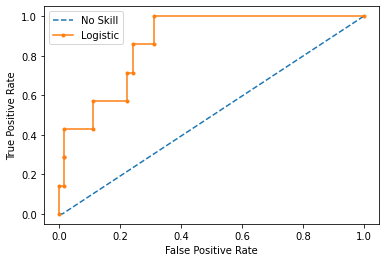

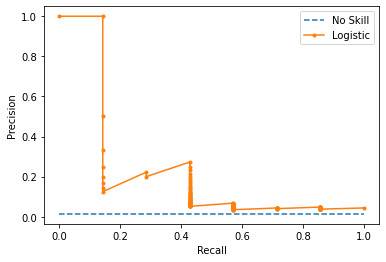

In [9]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
from matplotlib import pyplot
 
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
    # plot naive skill roc curve
    fpr, tpr, _ = roc_curve(test_y, naive_probs)
    pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
    # plot model roc curve
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

# pr curve and pr auc on an imbalanced dataset

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1)
# split into train/test sets with same class ratio
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, naive_probs)
print('No Skill ROC AUC %.3f' % roc_auc)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, model_probs)
print('Logistic ROC AUC %.3f' % roc_auc)

# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)

# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, model_probs)
auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)
# plot roc curves
plot_roc_curve(testy, naive_probs, model_probs)
plot_pr_curve(testy, model_probs)
